In [83]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns  

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import mean_squared_error,accuracy_score,f1_score
from sklearn.model_selection import train_test_split


In [84]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [85]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [86]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [87]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [88]:
df_rounded = df.round(2)

In [89]:
df_rounded.duplicated().sum()

np.int64(240)

In [90]:
def cap_outliers_iqr(data, columns):
    capped_df = data.copy()
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Cap the values
        capped_df[col] = capped_df[col].apply(lambda x: lower_limit if x < lower_limit else (upper_limit if x > upper_limit else x))
    
    return capped_df

In [91]:
numeric_cols = df.columns.drop('quality')

In [92]:
df_capped = cap_outliers_iqr(df, numeric_cols)

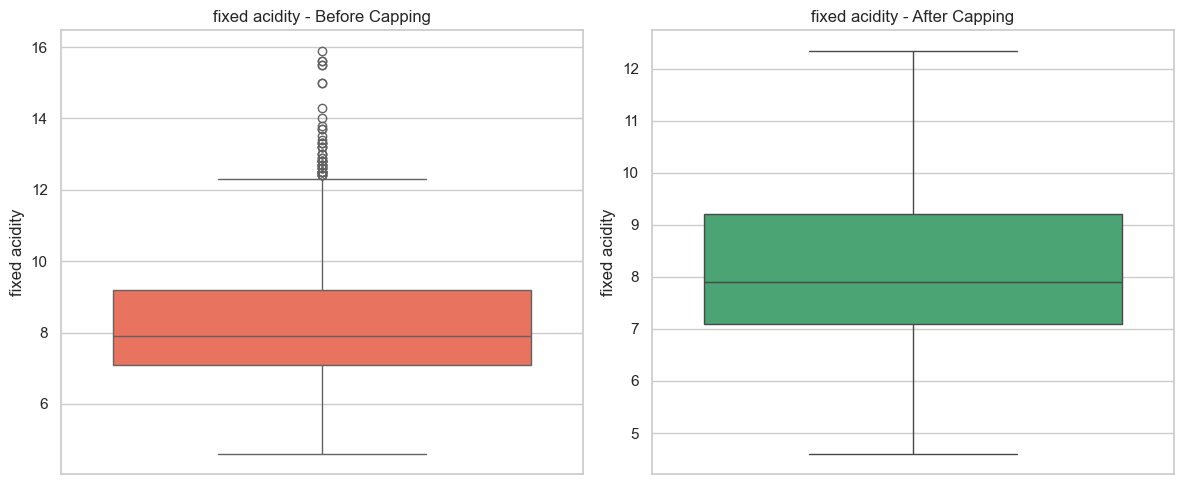

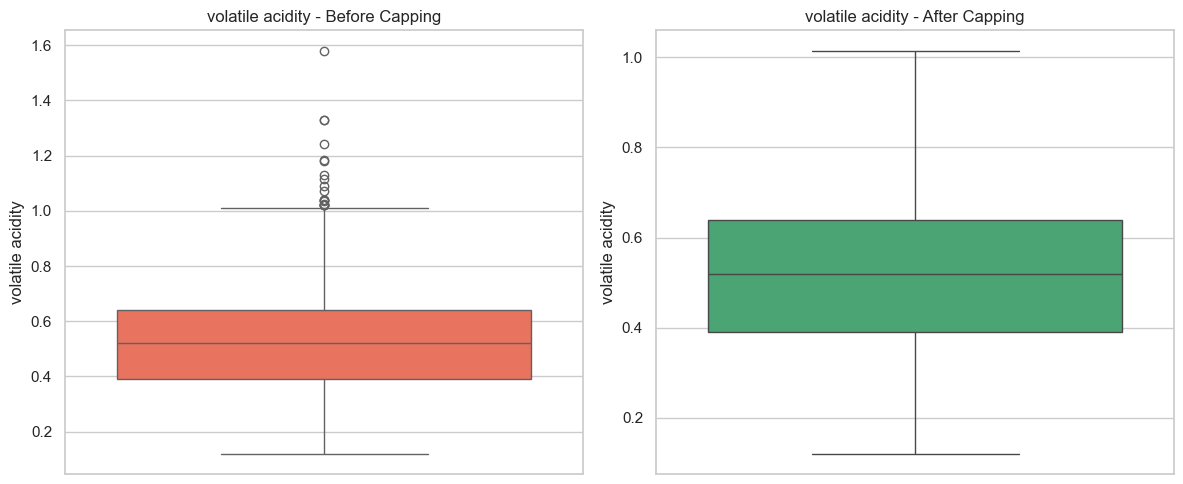

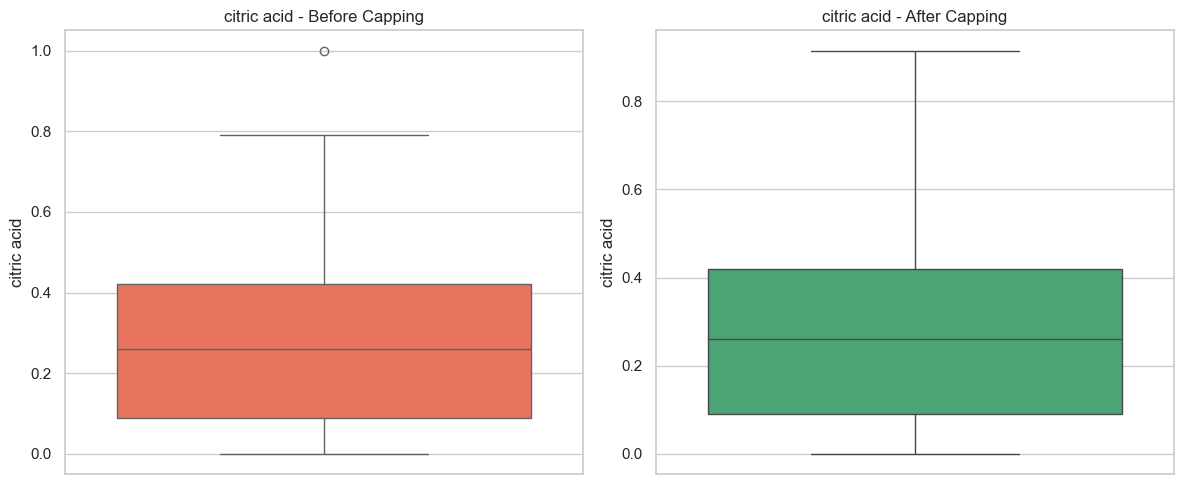

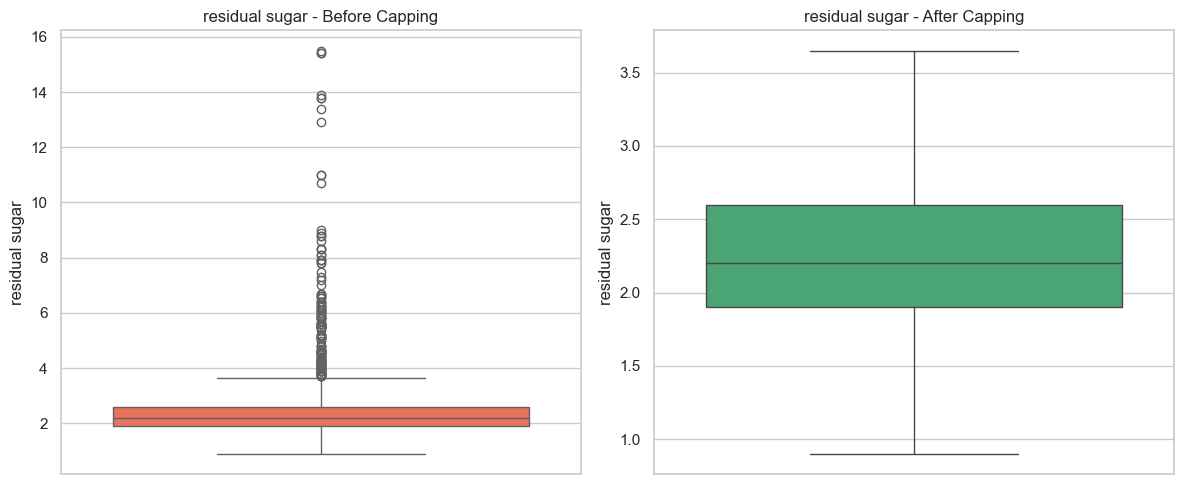

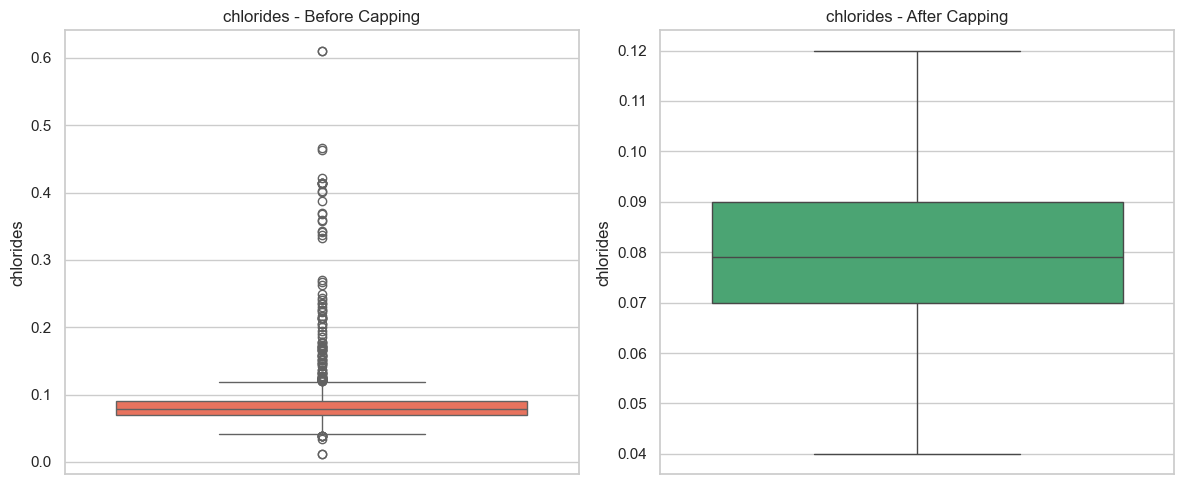

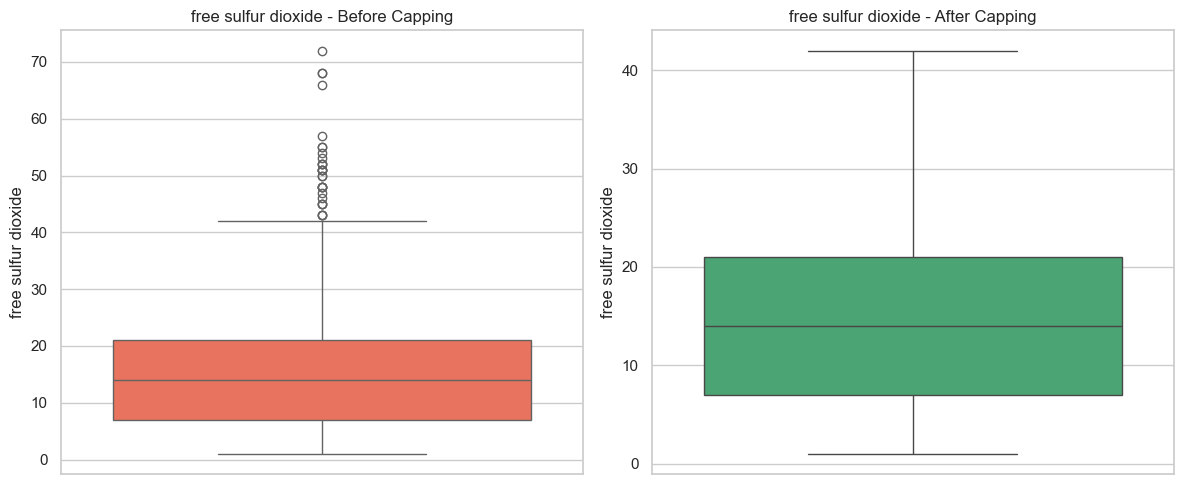

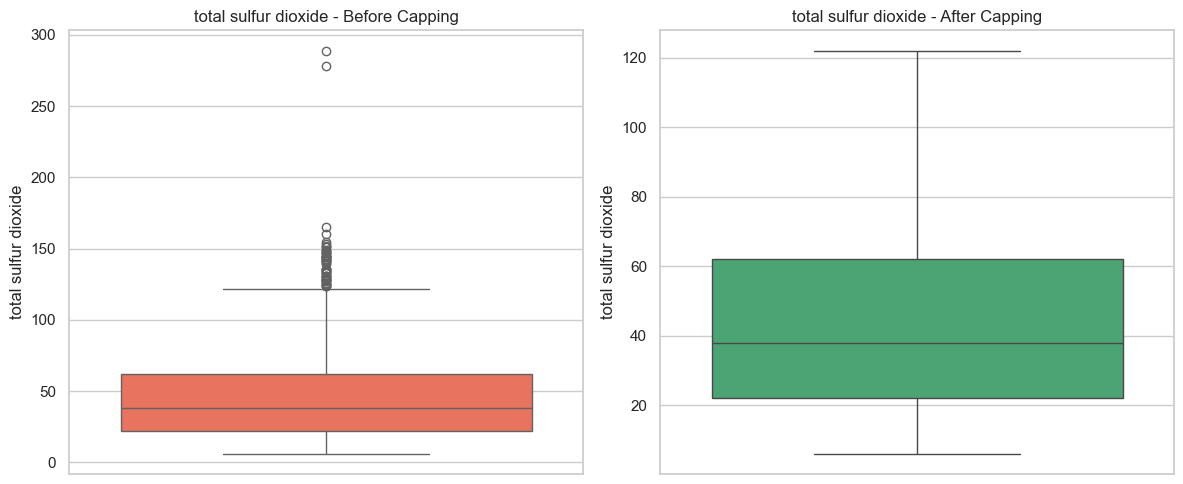

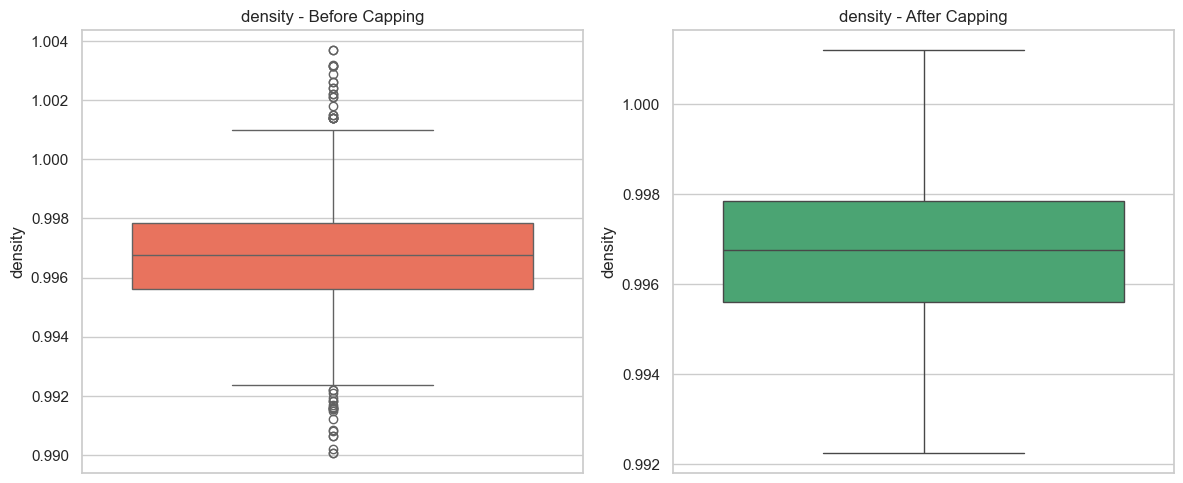

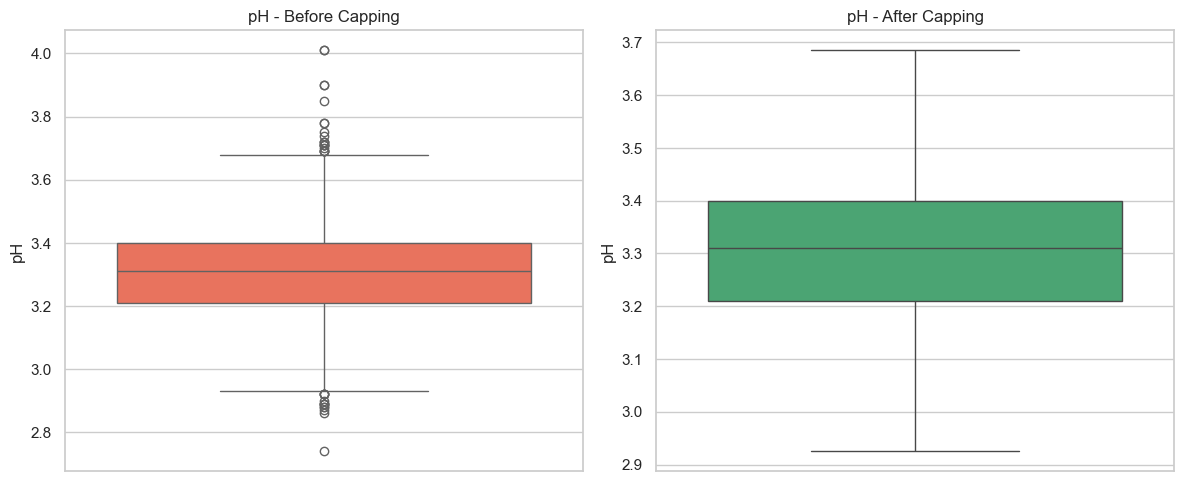

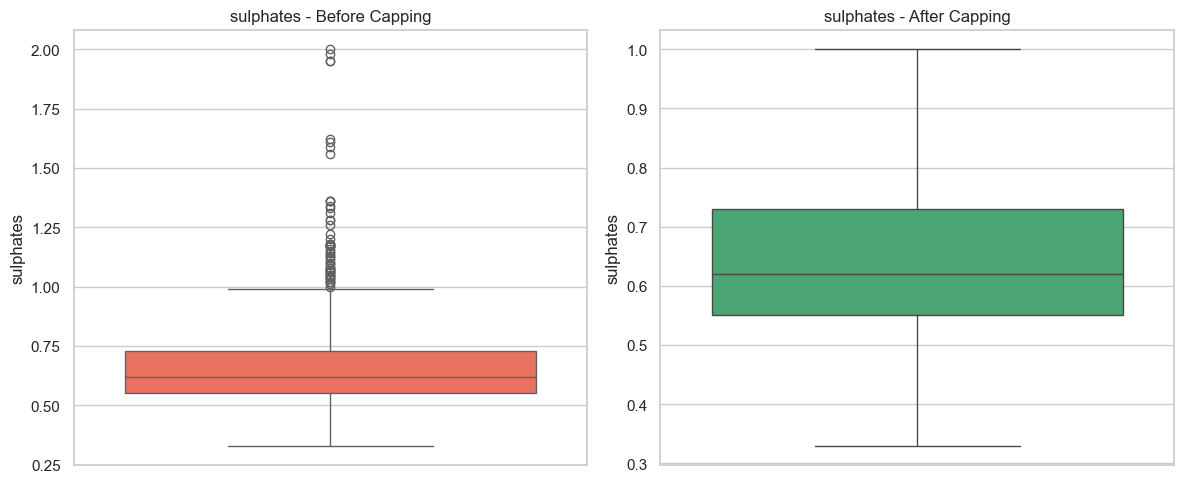

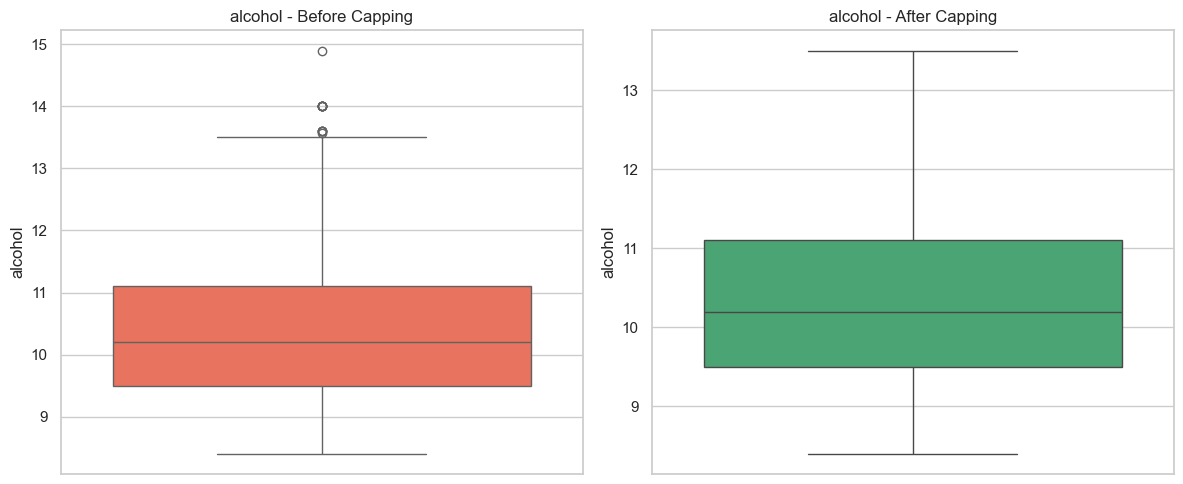

In [93]:
sns.set(style="whitegrid")

# Plotting function for side-by-side boxplots
def plot_boxplots_before_after(original_df, capped_df, columns):
    for col in columns:
        plt.figure(figsize=(12, 5))

        # Before
        plt.subplot(1, 2, 1)
        sns.boxplot(y=original_df[col], color="tomato")
        plt.title(f"{col} - Before Capping")

        # After
        plt.subplot(1, 2, 2)
        sns.boxplot(y=capped_df[col], color="mediumseagreen")
        plt.title(f"{col} - After Capping")

        plt.tight_layout()
        plt.show()

# Plot boxplots for all numeric features
plot_boxplots_before_after(df, df_capped, numeric_cols)

Bulding Models

Trying to train our model without prior analysis.

In [94]:
X, y = df.drop('quality', axis=1).values, df.quality
X.shape, y.shape

((1599, 11), (1599,))

In [95]:
# Binarize the target
y = y.apply(lambda x: int(x > 6))
print(y.unique())
y = y.values

[0 1]


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [97]:
# Сhecking that nothing was missed or mixed up.
y_train.sum(), y_test.sum(), y.sum()

(np.int64(163), np.int64(54), np.int64(217))

In [98]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        n_estimators=100,
        max_depth=6,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

In [99]:
pipeline.fit(X_train, y_train)

c:\Users\shami\Desktop\Desktop\Vine Prediction\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:26:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


**Training XGBoost over decision trees.**

In [100]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.9050


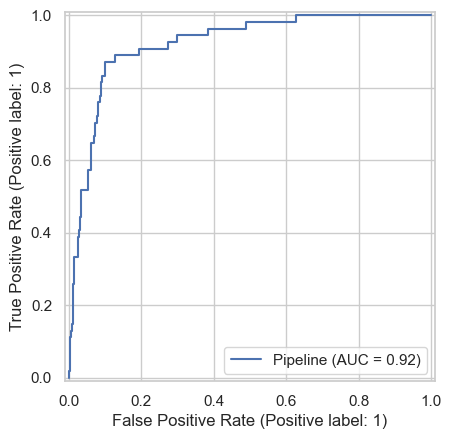

In [101]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

In [102]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [103]:
feature_names = [col for col in df.columns if col != 'quality']

In [ ]:
save_dir = "./models/FC211017_XGBoost_model"
os.makedirs(save_dir, exist_ok=True)


model_package = {
    'pipeline': pipeline,                        
    'feature_names': feature_names,              
    'model_name': 'XGBClassifier_with_scaler',   
    'accuracy': accuracy,                        
    'classes': pipeline.named_steps['xgb'].classes_,
    'training_date': datetime.now(),
    'parameters': pipeline.named_steps['xgb'].get_params(),
    'dataset_info': {
        'original_shape': df.shape,
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'class_distribution': dict(zip(*np.unique(y_train, return_counts=True)))
    }
}

# Save in .joblib format
model_filename = os.path.join(save_dir, "wine-quality-model-xgboost.joblib")
joblib.dump(model_package, model_filename)

# Save in .pkl format
pkl_filename = os.path.join(save_dir, "wine-quality-model-xgboost.pkl")
with open(pkl_filename, "wb") as f:
    pickle.dump(model_package, f)

print(f"Model package saved successfully!")
print(f"Joblib file: {model_filename}")
print(f"Pickle file: {pkl_filename}")


Model package saved successfully!
Joblib file: ./models/FC211017_XGBoost_model\xgb_model.joblib
Pickle file: ./models/FC211017_XGBoost_model\xgb_model.pkl
